# Multi-modal Vectors

These vectors come from the Azure AI Vision multimodal embedding model, which can represent both text and images in a 1024-dimensional space.


In [1]:
import json

with open('./data/images_ai-vision.json') as f:
    image_vectors = json.load(f)

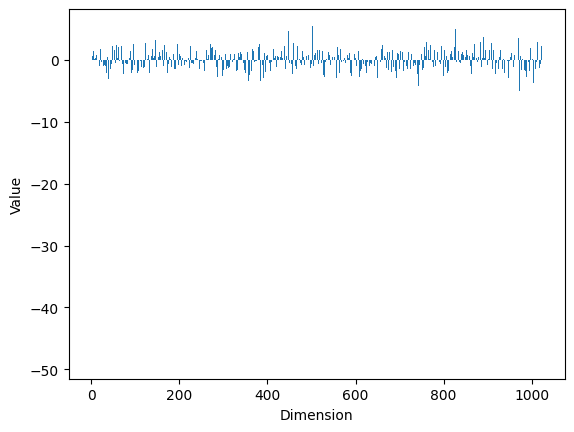

In [2]:
import random

import matplotlib.pyplot as plt

random_image_name = random.choice(list(image_vectors.keys()))
vector = image_vectors[random_image_name]

plt.bar(range(len(vector)), vector)
plt.xlabel('Dimension')
plt.ylabel('Value')
plt.show()

## Most similar to a target image

In [ ]:
import pandas as pd

def cosine_similarity(v1, v2):
    """Calculate the cosine similarity between two vectors"""
    dot_product = sum([a * b for a, b in zip(v1, v2)])
    magnitude = (sum([a**2 for a in v1]) * sum([a**2 for a in v2])) ** 0.5
    return dot_product / magnitude

def most_similar(target_vector: str, vectors: dict) -> list[list]:
    """Return the most similar images and their similarities relative to the given images"""
    similarities = {w: cosine_similarity(target_vector, vector) for w, vector in vectors.items()}
    most_similar = sorted(similarities, key=similarities.get, reverse=True)
    return pd.DataFrame([(vector_key, similarities[vector_key]) for vector_key in most_similar], columns=['vector key', 'similarity'])


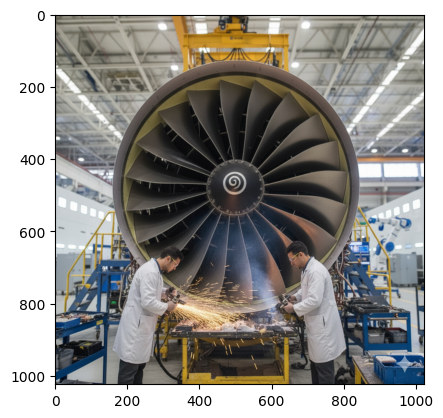

In [ ]:
# Render the target image
target_image = "planeMotor.png"
plt.imshow(plt.imread(f"./data/{target_image}"))

In [6]:
most_similar_df = most_similar(image_vectors[target_image], image_vectors)[0:3]
most_similar_df

,vector key,similarity
0,planeMotor.png,1.000000
1,planeMotor2.png,0.953565
2,planeMotor3.png,0.939478


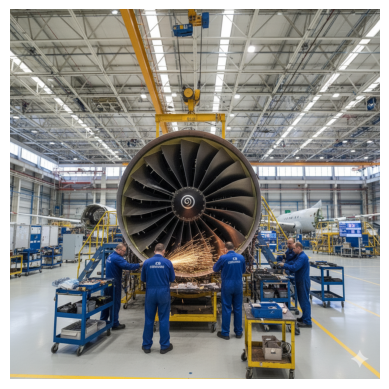

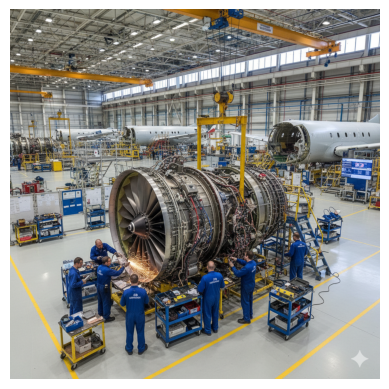

In [ ]:
# Now render each of those images
for image_name in most_similar_df['vector key'][1:]:
    plt.imshow(plt.imread(f'./data/{image_name}'))
    plt.axis('off')
    plt.show()

## Search with query vectors

In [ ]:
import os

import dotenv
import requests

dotenv.load_dotenv()

# API Key authentication
AZURE_AIVISION_API_KEY = ""
AZURE_COMPUTER_VISION_URL = f"https://multimodalaiservice.cognitiveservices.azure.com/"

def get_model_params():
    return {"api-version": "2024-02-01", "model-version": "2023-04-15"}

def get_auth_headers():
    return {"Ocp-Apim-Subscription-Key": AZURE_AIVISION_API_KEY}

def get_text_embedding(text):
    url = f"{AZURE_COMPUTER_VISION_URL}/computervision/retrieval:vectorizeText"
    headers = get_auth_headers()
    headers["Content-Type"] = "application/json"
    return requests.post(url, headers=headers, params=get_model_params(),
                         json={"text": text}).json()["vector"]

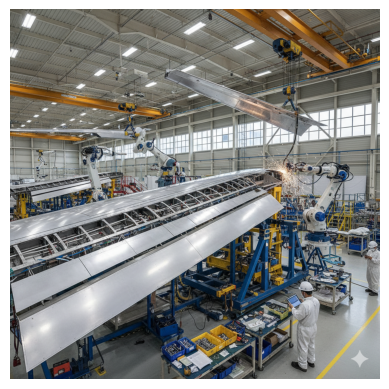

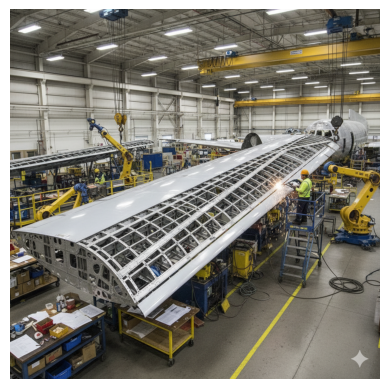

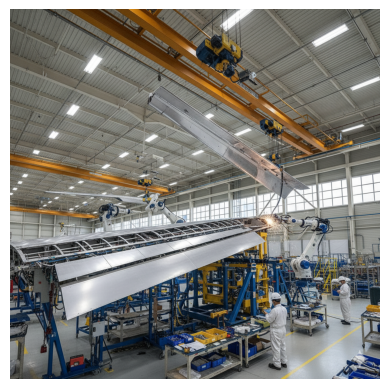

In [ ]:
embedding = get_text_embedding("Wing") # Examples: "Motor" "Shoe" "Plane"
most_similar_df = most_similar(embedding, image_vectors)

for image_name in most_similar_df['vector key'][0:3]:
    plt.imshow(plt.imread(f'./data/{image_name}'))
    plt.axis('off')
    plt.show()